In [1]:
import ROOT
from ROOT import TCanvas, TColor, TGraphErrors, TLegend
import numpy as np
import matplotlib.pyplot as plt;
import pandas as pd
import uproot

Welcome to JupyROOT 6.20/02


In [4]:
import pPb_analysis_utils as hp

## Compute Efficiency

In [6]:
df_rec = uproot.open("Tables/SignalTable_17d_mtexp.root")["SignalTable"].pandas.df()
df_sim = uproot.open("Tables/SignalTable_17d_mtexp.root")["GenTable"].pandas.df()

In [7]:
presel_eff = len(df_rec)/len(df_sim.query("abs(rapidity)<0.5"))

In [8]:
print("Pre-selection efficiency: ", presel_eff)

Pre-selection efficiency:  0.3165937970227676


# Invariant mass fits

In [9]:
df = pd.read_pickle("Utils/selected_dataframe.pkl")
score_cuts_array = np.load("Utils/score_efficiency_array.npy")

In [10]:
selected_bdt_eff = 0.72
bdt_eff_array = np.round(np.arange(selected_bdt_eff - 0.05, selected_bdt_eff + 0.05, 0.01),2)

In [19]:
ff = ROOT.TFile("Results/inv_mass_fits.root", "recreate")

signal_list = []
error_list = []

ff.cd()

for eff,cut in zip(bdt_eff_array, score_cuts_array):
    cut_string = f"model_output>{cut}"
    data = np.array(df.query(cut_string)["InvMass"])
    res = hp.unbinned_mass_fit(data, eff, 'pol0', ff, [0,90], [2,10], [0,35], split="", bins = 38);
    signal_list.append(res[0])
    error_list.append(res[1])

ff.Close()
    

[#1] INFO:Eval -- RooRealVar::setRange(m) new range named 'fit' created with bounds [2.96,3.04]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_model_data) constructing test statistic for sub-range named fit
[#1] INFO:Eval -- RooRealVar::setRange(m) new range named 'NormalizationRangeForfit' created with bounds [2.96,3.04]
[#1] INFO:Eval -- RooRealVar::setRange(m) new range named 'fit_nll_model_data' created with bounds [2.96,3.04]
[#1] INFO:Fitting -- RooAbsOptTestStatistic::ctor(nll_model_data) fixing interpretation of coefficients of any RooAddPdf to full domain of observables 
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (bkg)
[#1] INFO:Minization --  The following expressions will be evaluated in cache-and-track mode: (signal)
 **********
 **  100 **SET PRINT           1
 **********
 **********
 **  101 **SET NOGRAD
 

In [20]:
signal_array = np.array(signal_list)
error_array = np.array(error_list)

In [21]:
signal_array

array([ 9.25616806, 10.55305384, 12.04708539, 12.89762806, 14.2168646 ,
       16.61464762, 17.1180593 , 19.32998067, 19.33649904, 17.57951716,
       15.44554213])

# Computing yield

In [22]:
n_events = np.sum(uproot.open("Utils/AnalysisResults_pPb.root")["AliAnalysisTaskHyperTriton2He3piML_default_summary"][11])
branching_ratio = 0.25

In [23]:
corrected_counts = signal_array/n_events/branching_ratio/presel_eff/bdt_eff_array
corrected_error = error_array/n_events/branching_ratio/presel_eff/bdt_eff_array

In [24]:
Yield = np.float64(corrected_counts[bdt_eff_array==selected_bdt_eff]  / 2)
stat_error = np.float64(corrected_error[bdt_eff_array==selected_bdt_eff] / 2)
syst_error = np.std(corrected_counts) / 2

In [25]:
print(f"Yield [(matter + antimatter) / 2] = {Yield:.2e} +- {stat_error:.2e} (stat.) +- {syst_error:.2e} (syst.)")

Yield [(matter + antimatter) / 2] = 1.94e-07 +- 4.77e-08 (stat.) +- 3.26e-08 (syst.)


# Computing $S_3$

Published $\Lambda$ and proton yields taken from https://www.hepdata.net/record/ins1244523?version=2, $^3$He taken from https://www.hepdata.net/record/ins1762356

In [26]:
protonVals = [{"bin":[0.0, 5.0], "measure": [2.280446e+00, 4.394273e-03, 1.585968e-01, 7.001060e-02]},
{"bin":[5.0, 10.0], "measure": [1.853576e+00, 3.901768e-03, 1.284426e-01, 5.548104e-02]},
{"bin":[10.0, 20.0], "measure": [1.577375e+00, 2.739986e-03, 1.084793e-01, 4.467687e-02]},
{"bin":[20.0, 40.0], "measure": [1.221875e+00, 1.735134e-03, 8.190972e-02, 3.347605e-02]},
{"bin":[40.0, 60.0], "measure": [8.621290e-01, 1.381181e-03, 5.608663e-02, 2.265973e-02]},
{"bin":[60.0, 80.0], "measure": [5.341445e-01, 1.034190e-03, 3.408551e-02, 1.377331e-02]},
{"bin":[80.0, 100.0], "measure": [2.307767e-01, 6.969543e-04, 1.450569e-02, 6.911692e-03]}]
lambdaVals = [{"bin": [0.0, 5.0], "measure": [1.630610e+00, 7.069538e-03, 1.448270e-01, 7.144051e-02]},
{"bin": [5.0, 10.0], "measure": [1.303508e+00, 6.313141e-03, 1.122199e-01, 5.217514e-02]},
{"bin": [10.0, 20.0], "measure": [1.093400e+00, 4.432728e-03, 9.410049e-02, 4.447422e-02]},
{"bin": [20.0, 40.0], "measure": [8.332270e-01, 3.036428e-03, 6.919569e-02, 3.205334e-02]},
{"bin": [40.0, 60.0], "measure": [5.678968e-01, 2.357040e-03, 4.722551e-02, 2.110751e-02]},
{"bin": [60.0, 80.0], "measure": [3.355044e-01, 1.855427e-03, 2.871323e-02, 1.389226e-02]},
{"bin": [80.0, 100.0], "measure": [1.335216e-01, 1.353847e-03, 1.142858e-02, 6.444149e-03]}]

In [27]:
protonAv = hp.computeAverage(protonVals)
lambdaAv = hp.computeAverage(lambdaVals)
He3Av = [1.04e-06, 5.0e-08, 1.1e-07]

d$N$/d$\eta$ obtained by simple weighted average of the values published in https://arxiv.org/pdf/1910.14401.pdf

In [28]:
x_pPb = np.array([17.8], dtype=np.float64)
xe_pPb = np.array([0.4], dtype=np.float64)

$S_{3}$ calculation

In [29]:
s3 = np.array([Yield * protonAv[0] / (He3Av[0] * lambdaAv[0])], dtype=np.float64)
s3stat = np.array([s3[0] * hp.myHypot(stat_error / Yield, He3Av[1] / He3Av[0], protonAv[1] / protonAv[0], lambdaAv[1] / lambdaAv[0])], dtype=np.float64)
s3syst = np.array([s3[0] * hp.myHypot(syst_error / Yield, He3Av[2] / He3Av[0], protonAv[2] / protonAv[0], lambdaAv[2] / lambdaAv[0])], dtype=np.float64)

Plotting

Warning in <TCanvas::Constructor>: Deleting canvas with same name: cv


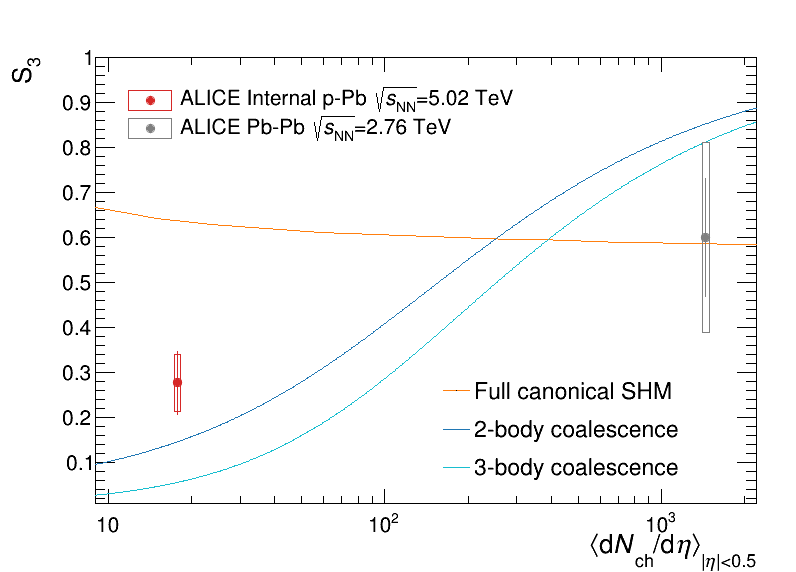

In [35]:
kBlueC  = TColor.GetColor("#2077b4");
kRedC  = TColor.GetColor("#d62827");
kGreenC  = TColor.GetColor("#2ba02b");
kOrangeC  = TColor.GetColor("#ff7f0f");
kVioletC  = TColor.GetColor("#9467bd");
kPinkC  = TColor.GetColor("#e377c1");
kGreyC  = TColor.GetColor("#7f7f7f");
kBrownC  = TColor.GetColor("#8c564c");
kAzureC  = TColor.GetColor("#18becf");
kGreenBC  = TColor.GetColor("#bcbd21");

s3_csm = TGraphErrors("Utils/FullCSM-S3.dat","%lg %*s %*s %*s %*s %*s %*s %*s %*s %*s %lg")
s3_csm.SetLineColor(kOrangeC)
s3_csm.SetLineWidth(1)
s3_csm.SetTitle("Full canonical SHM")
s3_2body = TGraphErrors("Utils/s3_2body.csv","%lg %lg %*s","\t,")
s3_2body.SetLineColor(kBlueC)
s3_2body.SetMarkerColor(kBlueC)
s3_2body.SetTitle("2-body coalescence")
s3_3body = TGraphErrors("Utils/s3_3body.csv","%lg %lg %*s","\t,")
s3_3body.SetLineColor(kAzureC)
s3_3body.SetMarkerColor(kAzureC)
s3_3body.SetTitle("3-body coalescence")

cv = TCanvas("cv")
cv.DrawFrame(9,0.01,2200,1.0,";#LTd#it{N}_{ch}/d#it{#eta}#GT_{|#it{#eta}|<0.5};S_{3}")
cv.SetLogx()
# cv.SetLogy()
s3_csm.Draw("L")
s3_2body.Draw("L")
s3_3body.Draw("L")

x = np.array([1447], dtype=np.float64)
ex = np.array([39], dtype=np.float64)
y = np.array([0.6], dtype=np.float64)
ey = np.array([0.13], dtype=np.float64)
eys = np.array([0.21], dtype=np.float64)
zero = np.array([0], dtype=np.float64)
pbpb_stat = TGraphErrors(1,x,y,zero,ey)
pbpb_stat.SetLineColor(kGreyC)
pbpb_stat.SetMarkerColor(kGreyC)
pbpb_stat.SetMarkerStyle(20)
pbpb_stat.Draw("Pz")

pbpb_syst = TGraphErrors(1,x,y,ex,eys)
pbpb_syst.SetTitle("ALICE Pb-Pb #sqrt{#it{s}_{NN}}=2.76 TeV")
pbpb_syst.SetLineColor(kGreyC)
pbpb_syst.SetMarkerColor(kGreyC)
pbpb_syst.SetFillStyle(0)
pbpb_syst.SetMarkerStyle(20)
pbpb_syst.Draw("P2")


ppb_stat = TGraphErrors(1,x_pPb,s3,zero,s3stat)
ppb_stat.SetLineColor(kRedC)
ppb_stat.SetMarkerColor(kRedC)
ppb_stat.SetMarkerStyle(20)
ppb_stat.Draw("Pz")
ppb_syst = TGraphErrors(1,x_pPb,s3,xe_pPb,s3syst)
ppb_syst.SetTitle("ALICE Internal p-Pb #sqrt{#it{s}_{NN}}=5.02 TeV")
ppb_syst.SetLineColor(kRedC)
ppb_syst.SetMarkerColor(kRedC)
ppb_syst.SetFillStyle(0)
ppb_syst.SetMarkerStyle(20)
ppb_syst.Draw("P2")
leg = TLegend(0.15,0.75,0.7,0.85)
leg.SetMargin(0.14)
leg.AddEntry(ppb_syst,"","pf")
leg.AddEntry(pbpb_syst,"","pf")
leg.SetEntrySeparation(0.2)
legT = TLegend(0.55,0.15,0.88,0.35)
legT.SetMargin(0.14)
legT.AddEntry(s3_csm)
legT.AddEntry(s3_2body)
legT.AddEntry(s3_3body)
leg.SetFillStyle(0)
legT.SetFillStyle(0)
leg.Draw()
legT.Draw()


cv.Draw()

In [ ]:
cv.SaveAs("Results/s3.pdf")